In [31]:
#| default_exp app

[LINK](https://www.kaggle.com/competitions/tabular-playground-series-mar-2022/data)

In this competition, you'll forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features give you the chance to model interactions across a network of roadways.

Files and Field Descriptions
----------------------------

*   train.csv - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.

*   row\_id - a unique identifier for this instance
*   time - the 20-minute period in which each measurement was taken
*   x - the east-west midpoint coordinate of the roadway
*   y - the north-south midpoint coordinate of the roadway
*   direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
*   congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.

*   test.csv - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.
*   sample\_submission.csv - a sample submission file in the correct format

Source
------

This dataset was derived from the [Chicago Traffic Tracker - Historical Congestion Estimates](https://www.google.com/url?q=https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/sxs8-h27x&sa=D&source=editors&ust=1679047966796262&usg=AOvVaw0Ubg-W85BHF1zlI4pfmhb6) dataset.

### Imports and Downloading Datasets

In [32]:
#| export
from fastai.tabular.all import *

from sklearn.ensemble import RandomForestRegressor

In [33]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [34]:
#| export
comp = 'tabular-playground-series-mar-2022'
path = setup_comp(comp, install='fastai')

### Transform Data

In [35]:
#| export
train_df = pd.read_csv(path/"train.csv", low_memory=False)
test_df = pd.read_csv(path/"test.csv", low_memory=False)
sample_df = pd.read_csv(path/"sample_submission.csv", low_memory=False)

Combine training and test sets

In [36]:
#| export
comb_df = pd.concat([train_df, test_df]).reset_index(drop=True)

Convert `time` to datetime format and split into separate `date` and `time_of_day` columns

In [37]:
#| export
comb_df['date'] = pd.to_datetime(comb_df.time)

In [38]:
#| export
comb_df['time_of_day'] = comb_df.date.dt.time
comb_df['date'] = comb_df.date.dt.date

In [39]:
#| export
comb_df['time_of_day'] = pd.to_timedelta(comb_df.time_of_day.astype(str))
comb_df['date'] = pd.to_datetime(comb_df.date)


Get indexes of training(~80%) and validation(~20%) sets

In [40]:
#| export
train_idxs = np.where(train_df.index <= (round(len(train_df) * .8)))
valid_idxs = np.where(train_df.index >= len(train_idxs[0]))
test_idxs = np.where(comb_df.index > train_df.index.max())

In [41]:
#| export
dep_var = 'congestion'

### Create Tabular Pandas Dataset

In [42]:
#| export
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(comb_df, 1, dep_var=dep_var)
train_val_splits = (list(train_idxs[0]), list(valid_idxs[0]))

In [43]:
#| export
to = TabularPandas(comb_df, procs, cat, cont, y_names=dep_var, splits=train_val_splits)

In [44]:
dls = to.dataloaders(1024)

In [45]:
#| export
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [46]:
y = to.train.y

In [47]:
y.min(), y.max()

(0.0, 100.0)

In [48]:
def train_res():
    train_data = pd.read_csv('history.csv')
    return train_data.head(n=50)

In [49]:
learn = tabular_learner(dls, layers=[500, 250], n_out=1, y_range=(0, 100), loss_func=F.l1_loss, cbs=[CSVLogger()])

SuggestedLRs(valley=0.0005754399462603033)

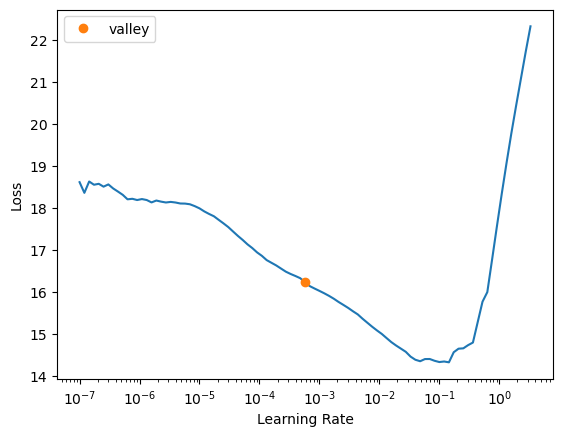

In [50]:
learn.lr_find()

In [51]:
learn.fit_one_cycle(3, 1e-2)
train_res()

,epoch,train_loss,valid_loss,time
0,0,7.139099,7.673975,00:06
1,1,6.471857,7.147294,00:06
2,2,5.722184,7.097500,00:06


In [52]:
test_dl = learn.dls.test_dl(comb_df.iloc[test_idxs])

In [53]:
preds = learn.get_preds(dl=test_dl)

In [54]:
preds

(tensor([[52.1280],
         [34.6405],
         [49.8098],
         ...,
         [74.0780],
         [13.3597],
         [42.1302]]),
 tensor([[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]))

In [55]:
len(test_df)

2340

In [56]:
len(preds[0])

2340

In [57]:
sample_df['congestion'] = preds[0]

In [58]:
sample_df

,row_id,congestion
0,848835,52.127998
1,848836,34.640491
2,848837,49.809807
3,848838,22.667372
4,848839,72.502098
...,...,...
2335,851170,67.672920
2336,851171,27.282467
2337,851172,74.078033
2338,851173,13.359724


In [59]:
submission = sample_df.to_csv("submission.csv", index=False)


In [60]:
import nbdev
nbdev.export.nb_export('traffic-flow.ipynb', 'app')
print("export successful")

export successful
